# Denoising using AutoEncoders

### Setup notebook

In [21]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from model import AutoEncoderCNN
from utils import add_noise, ssim, train, test


In [2]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)


1.9.0+cu111
cuda:0


## MIAS Dataset

### Download & extract the dataset

In [17]:
MIAS_URL = "http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz"
MIAS_DATASET_DIR = Path("./datasets/mias")
MIAS_MODEL_DIR = Path("./models/mias")
MIAS_RESULTS_DIR = Path("./results/mias")

if not MIAS_DATASET_DIR.exists():
    !mkdir {MIAS_DATASET_DIR / 'all-mias'}
    !wget -P {MIAS_DATASET_DIR} {MIAS_URL}
    !tar -xf {MIAS_DATASET_DIR / "all-mias.tar.gz"} --directory {MIAS_DATASET_DIR / 'all-mias'}

MIAS_MODEL_DIR.mkdir(parents=True, exist_ok=True)
MIAS_RESULTS_DIR.mkdir(parents=True, exist_ok=True)


### Setup training and testing sets

In [4]:
FEATURE_SHAPE = 64
BATCH_SIZE = 10
TRAIN_TEST_SPLIT = 0.9

# ? Resize the images and convert to grayscale tensors
transform = transforms.Compose(
    [
        transforms.Resize(FEATURE_SHAPE),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]
)

dataset = datasets.ImageFolder(MIAS_DATASET_DIR, transform)

# ? Split dataset into train and test sets
train_size = int(TRAIN_TEST_SPLIT * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# ? Create dataset loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
print(ssim(dataset[0]))


### Visualize dataset

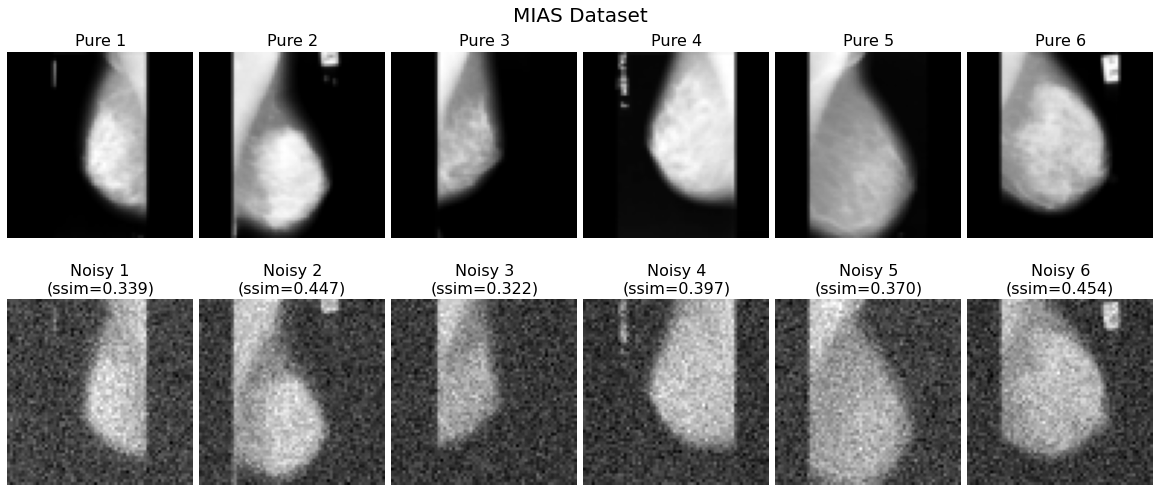

In [26]:
fig, axes = plt.subplots(2, 6, figsize=(16, 7), constrained_layout=True)
axes = list(map(list, zip(*axes)))
fig.suptitle("MIAS Dataset", fontsize=20)

for i, (ax1, ax2) in enumerate(axes):
    pure_img, _ = train_dataset[i]
    pure_img = pure_img.permute(1, 2, 0)

    ax1.imshow(pure_img, cmap="gray")
    ax1.axis("off")
    ax1.set_title(f"Pure {i+1}", fontsize=16)

    noisy_img = add_noise(pure_img)
    ssim_val = ssim(pure_img, noisy_img)
    ax2.imshow(noisy_img, cmap="gray")
    ax2.axis("off")
    ax2.set_title(f"Noisy {i+1}\n(SSIM: {ssim_val:.3f})", fontsize=16)

fig.savefig(MIAS_RESULTS_DIR / "dataset_sample.png", facecolor="w", transparent=False)


### Build & Train CNN based AutoEncoder Model

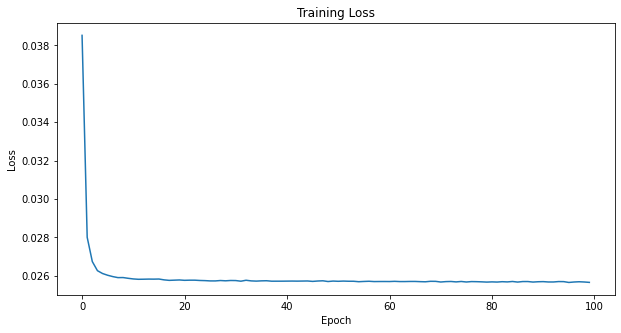

In [27]:
model = AutoEncoderCNN()
model.to(device)
print(model.parameters())

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_losses = train(
    model,
    train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=100,
    device=device,
    save_dir=MIAS_MODEL_DIR,
)


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(MIAS_RESULTS_DIR / "train_loss.png", facecolor="w", transparent=False)


### Test the model


In [29]:
model = AutoEncoderCNN()
model.load_state_dict(torch.load(MIAS_MODEL_DIR / "autoencodercnn_epoch_100.pth"))
model.to(device)

noisy_imgs, denoised_imgs = test(model, test_loader, criterion=criterion, device=device)


Average test loss: 0.032053


### Visualize results

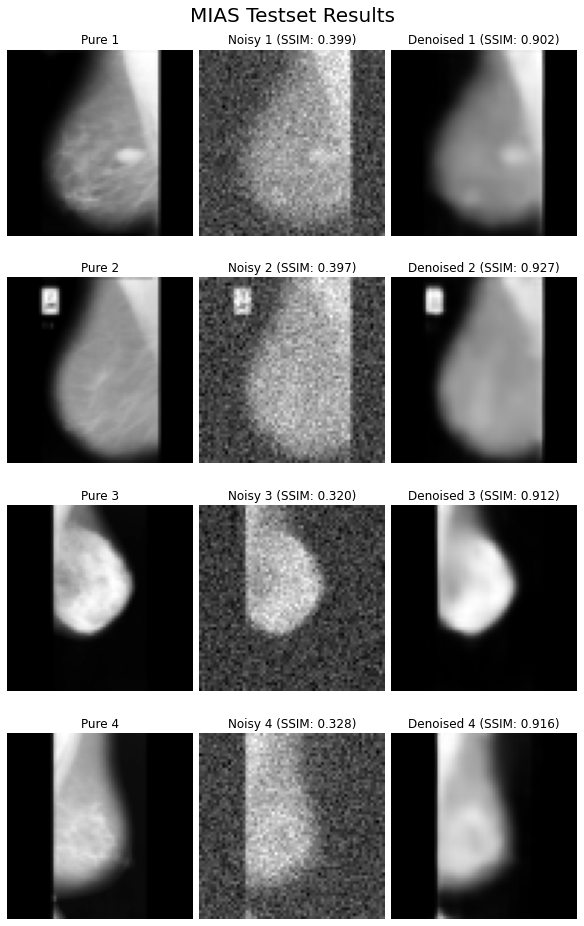

In [38]:
fig, axes = plt.subplots(4, 3, figsize=(8, 13), constrained_layout=True)
fig.suptitle("MIAS Testset Results", fontsize=20)

for i, ax in enumerate(axes):
    pure_img = test_dataset[i][0].permute(1, 2, 0).numpy()
    noisy_img = noisy_imgs[i].permute(1, 2, 0).numpy()
    denoised_img = denoised_imgs[i].permute(1, 2, 0).numpy()

    ssim_noisy = ssim(pure_img, noisy_img)
    ssim_denoised = ssim(pure_img, denoised_img)

    ax[0].imshow(pure_img, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title(f"Pure {i+1}")

    ax[1].imshow(noisy_img, cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Noisy {i+1} (SSIM: {ssim_noisy:.3f})")

    ax[2].imshow(denoised_img, cmap="gray")
    ax[2].axis("off")
    ax[2].set_title(f"Denoised {i+1} (SSIM: {ssim_denoised:.3f})")

fig.savefig(MIAS_RESULTS_DIR / "results.png", facecolor="w", transparent=False)
